# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

In [13]:
!pip install split-folders tqdm


In [14]:
#library 
import torch 
import numpy as np 
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import splitfolders


In [15]:

output = splitfolders.ratio("/data/landmark_images/train", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4996 files [00:01, 2591.86 files/s]


In [16]:
import os, os.path

# simple version for working with CWD
print ([name for name in os.listdir('output/val') ])


['26.Pont_du_Gard', '10.Edinburgh_Castle', '13.Yellowstone_National_Park', '14.Terminal_Tower', '01.Mount_Rainier_National_Park', '41.Machu_Picchu', '44.Trevi_Fountain', '30.Brooklyn_Bridge', '46.Great_Wall_of_China', '18.Delicate_Arch', '07.Stonehenge', '03.Dead_Sea', '05.London_Olympic_Stadium', '15.Central_Park', '17.Changdeokgung', '11.Mount_Rushmore_National_Memorial', '27.Seattle_Japanese_Garden', '39.Gateway_of_India', '38.Forth_Bridge', '20.Matterhorn', '28.Sydney_Harbour_Bridge', '45.Temple_of_Heaven', '29.Petronas_Towers', '48.Whitby_Abbey', '25.Banff_National_Park', '31.Washington_Monument', '00.Haleakala_National_Park', '33.Sydney_Opera_House', '35.Monumento_a_la_Revolucion', '09.Golden_Gate_Bridge', '32.Hanging_Temple', '40.Stockholm_City_Hall', '34.Great_Barrier_Reef', '02.Ljubljana_Castle', '24.Soreq_Cave', '23.Externsteine', '37.Atomium', '36.Badlands_National_Park', '47.Prague_Astronomical_Clock', '08.Grand_Canyon', '43.Gullfoss_Falls', '42.Death_Valley_National_Park',

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#---reproducibility 
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
#--------


batch_size = 20
validation_size = 0.2
num_workers = 0

#agumantation and pre-processing 
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(9),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
       transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}



train_path = 'output/train'
valid_path = 'output/val'
test_path = '/data/landmark_images/test'

train_data = datasets.ImageFolder(root = train_path,transform = data_transforms['train'])
valid_data = datasets.ImageFolder(root = valid_path,transform = data_transforms['test'])
test_data = datasets.ImageFolder(root = test_path,transform = data_transforms['test'])
train_len = len(train_data)
test_len = len(test_data)
valid_len = len(valid_data)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
     num_workers=num_workers,shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers,shuffle=False)



print('Nuumber  of training samples : ',train_len)
print('Nuumber  of validation samples : ',valid_len)
print('Nuumber  of testing samples : ',test_len)

#unique classes in the dataset 
classes_name = [c_name[3:].replace("_", " ") for c_name in train_loader.dataset.classes]
num_classes = len(classes_name)
print('\n ')
print("The unique classes of the images:")
for c in classes_name:
    print(c)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Nuumber  of training samples :  3996
Nuumber  of validation samples :  1000
Nuumber  of testing samples :  1250

 
The unique classes of the images:
Haleakala National Park
Mount Rainier National Park
Ljubljana Castle
Dead Sea
Wroclaws Dwarves
London Olympic Stadium
Niagara Falls
Stonehenge
Grand Canyon
Golden Gate Bridge
Edinburgh Castle
Mount Rushmore National Memorial
Kantanagar Temple
Yellowstone National Park
Terminal Tower
Central Park
Eiffel Tower
Changdeokgung
Delicate Arch
Vienna City Hall
Matterhorn
Taj Mahal
Moscow Raceway
Externsteine
Soreq Cave
Banff National Park
Pont du Gard
Seattle Japanese Garden
Sydney Harbour Bridge
Petronas Towers
Brooklyn Bridge
Washington Monument
Hanging Temple
Sydney Opera House
Great Barrier Reef
Monumento a la Revolucion
Badlands National Park
Atomium
Forth Bridge
Gateway of India
Stockholm City Hall
Machu Picchu
Death Valley National Park
Gullfoss Falls
Trevi Fountain
Temple of Heaven
Great Wall of China
Prague Astronomical Clock
Whitby Abbey

In [19]:
i,l = next(iter(train_loader))

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:  To find the best size and augmention effect I trained for evey expermints 15 epoch .

--------------
I try resize the images to 224 by 224 since its multiiplys of power 2 and used by many popular models as VGG16 ,VGG19,Resnet and EfficientNet B0  and 128 becasue the netwrok is small and I want to reduce the training time then I try 64 which smaller and I itested the validation loss and testing accurecy after 15 epochs of training.

224 
Validation Loss: 0.001304 Test Loss: 3.242174 Test Accuracy: 18% (230/1250)

128 
Validation Loss: 0.001425 Test Loss: 3.075313 Test Accuracy: 24% (303/1250)

64 

Training Loss: 0.000173 	Validation Loss: 0.000850
Test Loss: 2.979912 Test Accuracy: 27% (348/1250)
I also use center crop with size 224,128 and 64 for both test and train  and normalized the data so it have the same distribution and the gredient compution  not overwhelming by large pixel values.

Fist I don't do any augmention  and I see after epoch 9 the training loss keep decrease while the validation get increasing which sign of overfiting then I only used ranom rotation with degree of 9 and horizental flip for mirroring effect and I see the validation keep decreasing until the epoch 12 and it give me higher test accurecy by large margin 

Without augmention 
Training Loss: 0.000173 	Validation Loss: 0.000850
Test Loss: 2.979912 Test Accuracy: 27% (348/1250)

With augmention
Training Loss: 0.000369 	Validation Loss: 0.000550
Test Loss: 2.585609         Test Accuracy: 35% (448/1250)


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

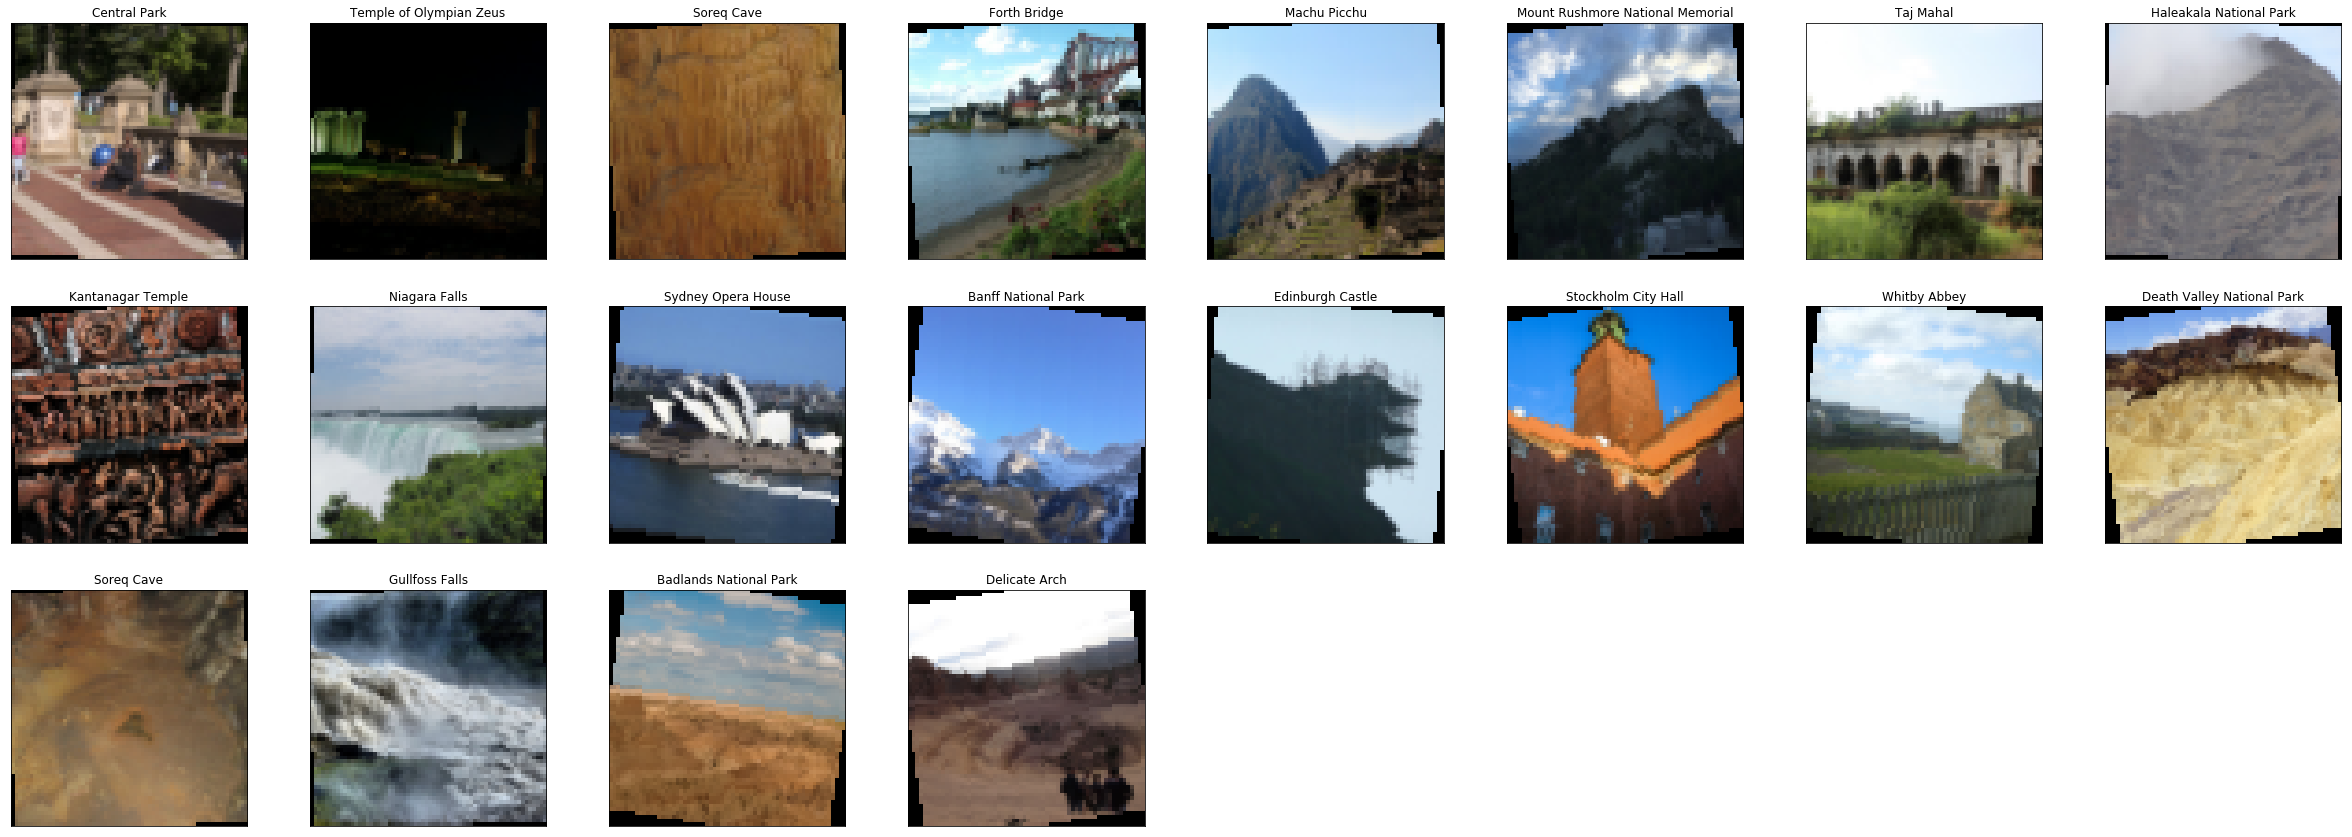

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
def image_show(img, label):
  #Un_normalized
    img = img = img / 2 + 0.5
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(label)
    #plt.show()
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
imgs,labels = next(iter(train_loader))
#grid with torch 
fig = plt.figure(figsize=(42, 20))
for i in range(len(imgs)):
    fig.add_subplot(4, 32/4, i+1, xticks=[], yticks=[])
    image_show(imgs[i], label=classes_name[labels[i]])




### Initialize use_cuda variable

In [21]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [22]:
## TODO: select loss function
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
#Multi_class 
criterion_scratch = CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return Adam(model.parameters(),lr=0.001)  

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [23]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        #input size 224 * 224 * 3
        self.conv1 = nn.Conv2d(3,16,3,padding =1)
        #input size 112 * 112 * 16
        self.conv2 = nn.Conv2d(16,32,3,padding =1)
        # input size  56 * 56 * 32
        self.conv3 = nn.Conv2d(32,64,3,padding =1)
        # input size  28 * 28 * 64
        self.conv4 = nn.Conv2d(64,128,3,padding =1)
        
        
        #input size 14 * 14 * 128
        self.fc1 = nn.Linear(4 * 4 * 128, 500)
        #output is 50 class 
        self.fc2 = nn.Linear(500,50)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.20)
        
        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.max_pool(F.relu(self.conv3(x)))
        x = self.max_pool(F.relu(self.conv4(x)))
        
        #flatten 
       
        x = x.view(-1,4 * 4 * 128)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [24]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
I used 4 convolutional  layers since the data is more complix  than that we used in the course for  MNIST  and Fashan-MNIST dataset .Also I used filters of size 3 and padding 1 to preseve the size of the input and I put between each conv layer a max pooling of size 2 and stride 2 to reduce the spatial dimensions by half and extract most relvent data  .I increases the filter numbers from 16 to 128 to increase the depth and  learn more complex features.I used 2 linear layer and I add Dropout with 20% to prevent overfitting 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [25]:
from tqdm import tqdm
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            #clear the acumalted  grad
            optimizer.zero_grad()
                #output of the model    
            output = model(data)
                #loss 
            loss = criterion(output,target)
                # back propagation
            loss.backward()
                #update the weights
            optimizer.step()
                #update the training loss 
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            #print('step {} : loss : {}'.format(batch_idx,train_loss))
            
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
          
        train_loss = train_loss /  len(loaders['train'].dataset)
        valid_loss = valid_loss /  len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validtion loss decreased from ({:.6f}) into ({:.6f})'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [26]:
def custom_weight_init(m):
    
    ## TODO: implement a weight initialization strategy
    #uniform_iintialization 
    classname = m.__class__.__name__
    # for every Conv layer in a model..
    if classname.find('Conv2d') != -1:
        torch.nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
        m.bias.data.fill_(0)
      # for every linear layer in a model.. 
    if classname.find('Linear') != -1:
        # get the number of the inputs
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	 Training Loss: 0.000946 	Validation Loss: 0.003585
Validtion loss decreased from (inf) into (0.003585)
Epoch: 2 	 Training Loss: 0.000851 	Validation Loss: 0.003370
Validtion loss decreased from (0.003585) into (0.003370)
Epoch: 3 	 Training Loss: 0.000785 	Validation Loss: 0.003187
Validtion loss decreased from (0.003370) into (0.003187)
Epoch: 4 	 Training Loss: 0.000726 	Validation Loss: 0.002955
Validtion loss decreased from (0.003187) into (0.002955)
Epoch: 5 	 Training Loss: 0.000671 	Validation Loss: 0.002950
Validtion loss decreased from (0.002955) into (0.002950)
Epoch: 6 	 Training Loss: 0.000613 	Validation Loss: 0.002893
Validtion loss decreased from (0.002950) into (0.002893)
Epoch: 7 	 Training Loss: 0.000568 	Validation Loss: 0.002899
Epoch: 8 	 Training Loss: 0.000509 	Validation Loss: 0.002843
Validtion loss decreased from (0.002893) into (0.002843)
Epoch: 9 	 Training Loss: 0.000471 	Validation Loss: 0.002788
Validtion loss decreased from (0.002843) into (0

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [27]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 25

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	 Training Loss: 0.000969 	Validation Loss: 0.003797
Validtion loss decreased from (inf) into (0.003797)
Epoch: 2 	 Training Loss: 0.000934 	Validation Loss: 0.003695
Validtion loss decreased from (0.003797) into (0.003695)
Epoch: 3 	 Training Loss: 0.000905 	Validation Loss: 0.003540
Validtion loss decreased from (0.003695) into (0.003540)
Epoch: 4 	 Training Loss: 0.000856 	Validation Loss: 0.003436
Validtion loss decreased from (0.003540) into (0.003436)
Epoch: 5 	 Training Loss: 0.000810 	Validation Loss: 0.003239
Validtion loss decreased from (0.003436) into (0.003239)
Epoch: 6 	 Training Loss: 0.000769 	Validation Loss: 0.003124
Validtion loss decreased from (0.003239) into (0.003124)
Epoch: 7 	 Training Loss: 0.000722 	Validation Loss: 0.003071
Validtion loss decreased from (0.003124) into (0.003071)
Epoch: 8 	 Training Loss: 0.000685 	Validation Loss: 0.003017
Validtion loss decreased from (0.003071) into (0.003017)
Epoch: 9 	 Training Loss: 0.000650 	Validation Loss: 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [28]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.656739


Test Accuracy: 33% (420/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

Since I used ResNet50 I will use the same pre-processing step 
https://pytorch.org/hub/pytorch_vision_resnet/

In [29]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes



### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# inception expected input shape N x 3 x 299 x 299


batch_size = 32
validation_size = 0.2
num_workers = 0
#---- inception input specification ---

mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
img_size = 224
##-----------

#agumantation and pre-processing 
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(9),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]),
    'test': transforms.Compose([
       transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ])
}



train_path = 'output/train'
valid_path = 'output/val'
test_path = '/data/landmark_images/test'

train_data = datasets.ImageFolder(root = train_path,transform = data_transforms['train'])
valid_data = datasets.ImageFolder(root = valid_path,transform = data_transforms['test'])
test_data = datasets.ImageFolder(root = test_path,transform = data_transforms['test'])
train_len = len(train_data)
test_len = len(test_data)
valid_len = len(valid_data)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
     num_workers=num_workers,shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers,shuffle=False)



print('Nuumber  of training samples : ',train_len)
print('Nuumber  of validation samples : ',valid_len)
print('Nuumber  of testing samples : ',test_len)

#unique classes in the dataset 
classes_name = [c_name[3:].replace("_", " ") for c_name in loaders_scratch['train'].dataset.classes]
num_classes = len(classes_name)
print('\n ')
print("The unique classes of the images:")
for c in classes_name:
    print(c)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Nuumber  of training samples :  3996
Nuumber  of validation samples :  1000
Nuumber  of testing samples :  1250

 
The unique classes of the images:
Haleakala National Park
Mount Rainier National Park
Ljubljana Castle
Dead Sea
Wroclaws Dwarves
London Olympic Stadium
Niagara Falls
Stonehenge
Grand Canyon
Golden Gate Bridge
Edinburgh Castle
Mount Rushmore National Memorial
Kantanagar Temple
Yellowstone National Park
Terminal Tower
Central Park
Eiffel Tower
Changdeokgung
Delicate Arch
Vienna City Hall
Matterhorn
Taj Mahal
Moscow Raceway
Externsteine
Soreq Cave
Banff National Park
Pont du Gard
Seattle Japanese Garden
Sydney Harbour Bridge
Petronas Towers
Brooklyn Bridge
Washington Monument
Hanging Temple
Sydney Opera House
Great Barrier Reef
Monumento a la Revolucion
Badlands National Park
Atomium
Forth Bridge
Gateway of India
Stockholm City Hall
Machu Picchu
Death Valley National Park
Gullfoss Falls
Trevi Fountain
Temple of Heaven
Great Wall of China
Prague Astronomical Clock
Whitby Abbey

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [30]:
## TODO: select loss function
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

criterion_transfer = CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return Adam(model.parameters(),lr=0.0001) 

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

Si
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3

In [31]:
## TODO: Specify model architecture
import torchvision.models as models
num_classes = 50

model_transfer = models.resnet50(pretrained=True)
#input_feature for the classifier 
in_features = model_transfer.fc.in_features 

classifer = nn.Linear(in_features,num_classes)
# freez the layers 
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = classifer
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 72304886.06it/s]


In [32]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I was wanting to used EfficientNet but I dont find it in the torchvision models because It the accomplish the state of the art results in Image Net and have different version that suited for different scenarios of  computation resources  ,so I try to used ResNeXt but it always throw errors in the workspace ,so I
choose ResNet50 since it score higher accurecy in Imagenet  than vgg16 and have layers that prove to benficial in deep learning as Resdual connections and Batch Normalization. 
Then becuse the dataset is small and the dataset images  is similar to some of the images that in ImageNet I used the ResNet50 as featuure extractor and I replaced the final fully connected  layer with new fully connected  layer of my output classes . 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [33]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
from tqdm import tqdm
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            #clear the acumalted  grad
            optimizer.zero_grad()
                #output of the model    
            output = model(data)
                #loss 
            loss = criterion(output,target)
                # back propagation
            loss.backward()
                #update the weights
            optimizer.step()
                #update the training loss 
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            #print('step {} : loss : {}'.format(batch_idx,train_loss))
            
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
          
        train_loss = train_loss /  len(loaders['train'].dataset)
        valid_loss = valid_loss /  len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validtion loss decreased from ({:.6f}) into ({:.6f})'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
        
        
    return model

model_transfer = train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer.fc), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	 Training Loss: 0.000926 	Validation Loss: 0.003364
Validtion loss decreased from (inf) into (0.003364)
Epoch: 2 	 Training Loss: 0.000797 	Validation Loss: 0.002930
Validtion loss decreased from (0.003364) into (0.002930)
Epoch: 3 	 Training Loss: 0.000700 	Validation Loss: 0.002572
Validtion loss decreased from (0.002930) into (0.002572)
Epoch: 4 	 Training Loss: 0.000621 	Validation Loss: 0.002283
Validtion loss decreased from (0.002572) into (0.002283)
Epoch: 5 	 Training Loss: 0.000561 	Validation Loss: 0.002076
Validtion loss decreased from (0.002283) into (0.002076)
Epoch: 6 	 Training Loss: 0.000513 	Validation Loss: 0.001933
Validtion loss decreased from (0.002076) into (0.001933)
Epoch: 7 	 Training Loss: 0.000477 	Validation Loss: 0.001800
Validtion loss decreased from (0.001933) into (0.001800)
Epoch: 8 	 Training Loss: 0.000444 	Validation Loss: 0.001696
Validtion loss decreased from (0.001800) into (0.001696)
Epoch: 9 	 Training Loss: 0.000419 	Validation Loss: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [34]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.233782


Test Accuracy: 73% (924/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [35]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    #read as pillow to transform it with pytorch transformer
    image = Image.open(img_path)
   #Use transformers as same as the test 
    image = data_transforms['test'](image)
    #add dimension for the batch 
    image = image.unsqueeze(0)
    if use_cuda:
            image = image.cuda()
         
    output = model_transfer(image)
    pred = output.data.topk(k,sorted = True)[1]
    pred = list(pred[0].cpu().numpy())
    
    pred_classes = [classes_name[c]  for c in pred] 
    return pred_classes
    

# test on a sample image

predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Brooklyn Bridge',
 'Sydney Opera House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

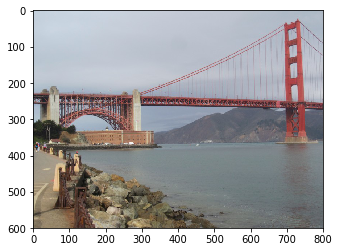

Is this picture of the Golden Gate Bridge or Forth Bridge or Sydney Harbour Bridge ?


In [36]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print the image
    plt.imshow(image)
    plt.show()
    print('Is this picture of the {} ?'.format(" or ".join(predicted_landmarks)))
    
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)


 I see its better than I expected since  it correctly predicted images that in the night or have some distortion but it only 4 here 
 
1. I will try more augmentation settings since, as in the model from scratch, and it improves it by a good margin. 
2. I will try different Architectures for the transfer learning effecentNet since the state-of-the-art models in ImageNet competition use it and provide some smaller versions and ResNext, which I want to use, but the workspace gives me errors.
3. train for more epochs and add more layers to capture more complex patterns 
4. I will try different optimizers and learning rates and learning rate schedulers to decrease the learning rate with the epochs 

5. Testing with more images to accuurtly measure the moddel generality 

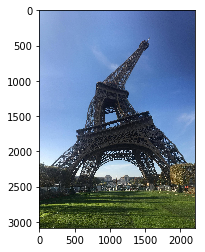

Is this picture of the Eiffel Tower or Vienna City Hall or Terminal Tower ?


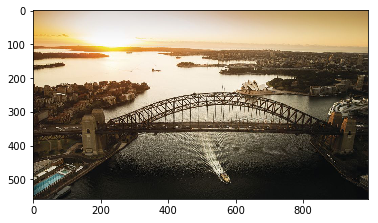

Is this picture of the Sydney Harbour Bridge or Forth Bridge or Eiffel Tower ?


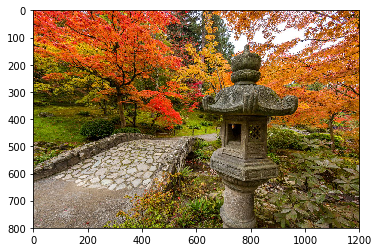

Is this picture of the Seattle Japanese Garden or Temple of Heaven or Taj Mahal ?


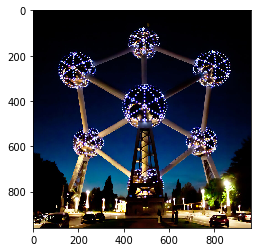

Is this picture of the Atomium or Vienna City Hall or Temple of Heaven ?


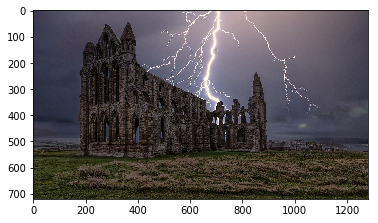

Is this picture of the Whitby Abbey or Vienna City Hall or Great Wall of China ?


In [37]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
evielTwoer = 'images/evielTwoer.jpeg'
Sydney_Harbour_Bridge='images/Sydney_Harbour_Bridge.jpeg'
Seattle_Japanese_Garden='images/Seattle_Japanese_Garden.jpg'
Atomium='images/Atomium.jpeg'
Whitby_Abbey='images/Whitby_Abbey.jpeg'
suggest_locations(evielTwoer)

suggest_locations(Sydney_Harbour_Bridge)

suggest_locations(Seattle_Japanese_Garden)

suggest_locations(Atomium)

suggest_locations(Whitby_Abbey)
